## Segmentation (not finished)

In [1]:
import os,sys
import h5py
import numpy as np
import time
from matplotlib import pyplot as plt

# https://github.com/zudi-lin/waterz
# https://github.com/zudi-lin/zwatershed
import waterz
from zwatershed import zwatershed

from torch_connectomics.utils.seg.seg_util import relabel
from torch_connectomics.utils.seg.seg_eval import adapted_rand

# functions for generating affinity graph
from torch_connectomics.utils.seg.aff_util import affinitize, seg_to_affgraph
from torch_connectomics.utils.seg.seg_util import widen_border, mknhood3d

In [2]:
def writeh5(filename, dtarray, datasetname='main'):
    fid=h5py.File(filename,'w')
    if isinstance(datasetname, (list,)):
        for i,dd in enumerate(datasetname):
            ds = fid.create_dataset(dd, dtarray[i].shape, compression="gzip", dtype=dtarray[i].dtype)
            ds[:] = dtarray[i]
    else:
        ds = fid.create_dataset(datasetname, dtarray.shape, compression="gzip", dtype=dtarray.dtype)
        ds[:] = dtarray
    fid.close()
                                                                            
def readh5(filename, datasetname='main'):
    return np.array(h5py.File(filename,'r')[datasetname])

def show_imgs(imgs, label=None, cmap=None):
    plt.figure(figsize=(16,4))
    for i in range(1,5):
        plt.subplot('14%d' % (i))
        if cmap is not None:
            plt.imshow(imgs[i-1], cmap=cmap)
        else:
            plt.imshow(imgs[i-1])
        if label is not None:
            plt.title(label+' '+str(i))
    plt.show()

### 1. Load predicted affinity

Show the affinity map (3 channels in z,y,x) in RGB style (channel last). For Harvard Research Computing (RC) cluster users, you can directly access the dsta directory if you have access to the `coxfs01` partition. For external users please change the data path accordingly.

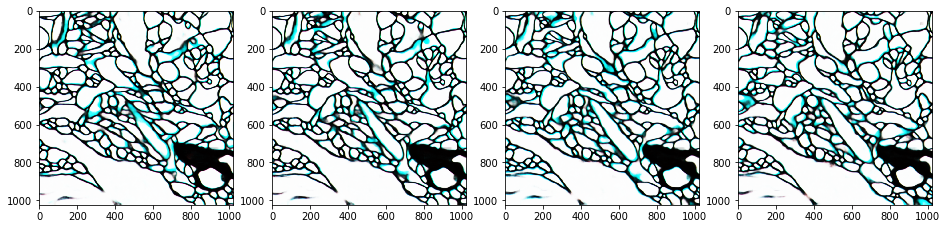

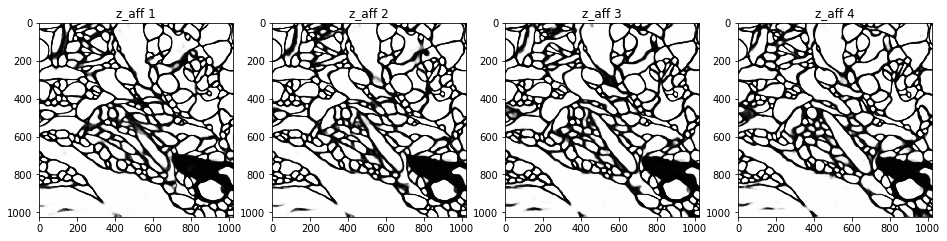

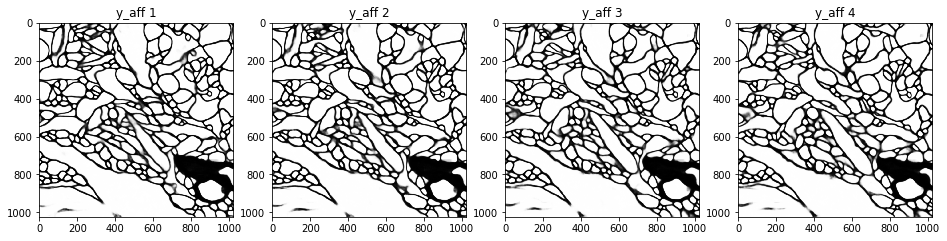

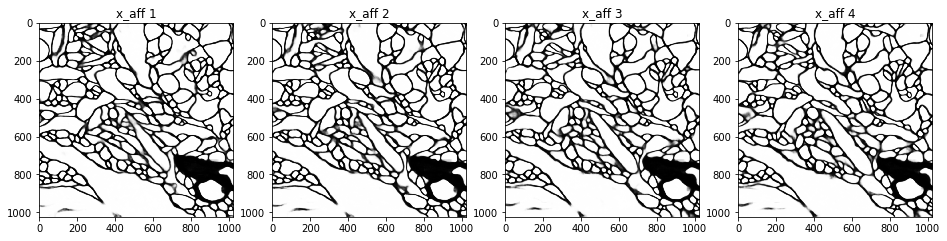

In [3]:
data_path = '/n/coxfs01/zudilin/data/SNEMI3D/'
aff = readh5(data_path + 'train_aff_pred.h5')

show_affs = aff[:,10:14].transpose(1,2,3,0)
show_imgs(show_affs)
show_imgs(show_affs[:,:,:,0], label='z_aff', cmap='gray')
show_imgs(show_affs[:,:,:,1], label='y_aff', cmap='gray')
show_imgs(show_affs[:,:,:,2], label='x_aff', cmap='gray')

### 2. Generate 2D watershed results

Generate 2D segmentation maps using zwatershed. The predicted affinity graph is in np.uint8 and has range [0, 255]. Need to convert the prediction into np.float32 and normalize to [0,1].

In [4]:
T_thres = 150
T_dust=150
T_low = 0.05
T_high = 0.8
T_dust_merge = 0.5
T_rel = False

aff = aff.astype(np.float32) / 255.0
out = np.zeros(aff.shape[1:], np.uint32)
for zid in range(aff.shape[1]):
    print('process %d/%d'%(zid, aff.shape[1]))
    out[zid] = zwatershed(np.array(aff[:,zid:zid+1]), T_threshes=[T_thres], 
                          T_dust=T_dust, T_aff=[T_low,T_high,T_dust_merge], 
                          T_aff_relative=T_rel, T_merge=T_dust_merge)[0][0][0]
    if zid>=4: break # just show first several sections

process 0/100
('1. affinity threshold: ', [0.05, 0.8, 0.5])
2. get initial seg
dict_keys([b'counts', b'rg', b'seg'])
('3. do thres: ', 150, 150)
	 number of regions: 275
process 1/100
('1. affinity threshold: ', [0.05, 0.8, 0.5])
2. get initial seg
dict_keys([b'counts', b'rg', b'seg'])
('3. do thres: ', 150, 150)
	 number of regions: 278
process 2/100
('1. affinity threshold: ', [0.05, 0.8, 0.5])
2. get initial seg
dict_keys([b'counts', b'rg', b'seg'])
('3. do thres: ', 150, 150)
	 number of regions: 277
process 3/100
('1. affinity threshold: ', [0.05, 0.8, 0.5])
2. get initial seg
dict_keys([b'counts', b'rg', b'seg'])
('3. do thres: ', 150, 150)
	 number of regions: 283
process 4/100
('1. affinity threshold: ', [0.05, 0.8, 0.5])
2. get initial seg
dict_keys([b'counts', b'rg', b'seg'])
('3. do thres: ', 150, 150)
	 number of regions: 275


### 3. Show 2D segmentation

In [5]:
def shuffle_index(seg):
    # shuffle the seg indexes for visualization purpose
    temp = seg.copy()
    seg_id = np.unique(seg)[1:]
    shuffled_id = seg_id.copy()
    np.random.shuffle(shuffled_id)
    for i in range(len(seg_id)):
        # print(i, seg_id[i], shuffled_id[i]) # debug
        temp[np.where(seg==seg_id[i])] = shuffled_id[i]
    return temp

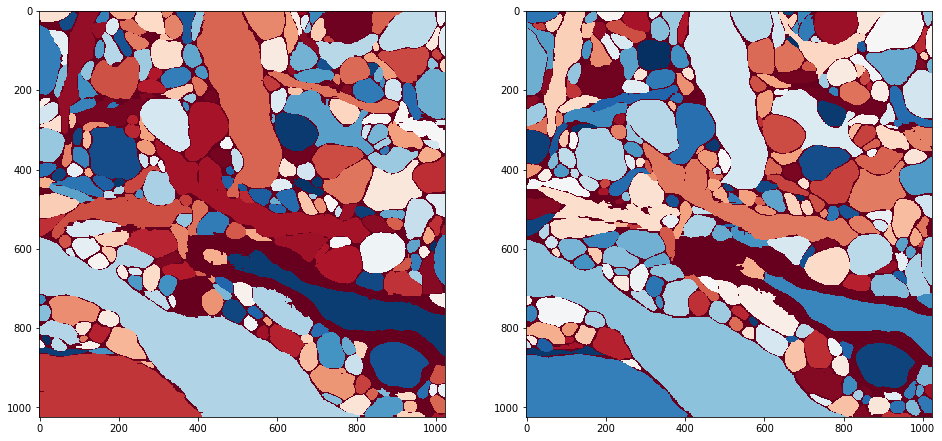

In [6]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(shuffle_index(out[0]), cmap='RdBu')
plt.subplot(122)
plt.imshow(shuffle_index(out[1]), cmap='RdBu')
plt.show()

### 3. Generate 3D watershed results (*zwatershed*)

Generate 3D segmentation results using zwatershed. Use the parameters as indicated in Lee et al. Superhuman Accuracy on the SNEMI3D Connectomics Challenge (https://arxiv.org/pdf/1706.00120.pdf).

In [7]:
# load gt
gt = readh5(data_path + 'train_label.h5').astype(np.uint32)

# Use the parameters as indicated in Lee et al.
T_aff=[0.01,0.8,0.2]
T_thres = [800]
T_dust=600
T_merge=0.5
T_aff_rel=True
out = zwatershed(aff, T_thres, T_aff=T_aff, \
                 T_dust=T_dust, T_merge=T_merge, T_aff_relative=T_aff_rel)[0][0]
out = relabel(out)

# evaluation
score = adapted_rand(out.astype(np.uint32), gt)
print(score)

('1. affinity threshold: ', array([0.        , 0.99215686, 0.07843138]))
2. get initial seg
dict_keys([b'counts', b'rg', b'seg'])
('3. do thres: ', 800, 600)
	 number of regions: 635
0.9197572889460701


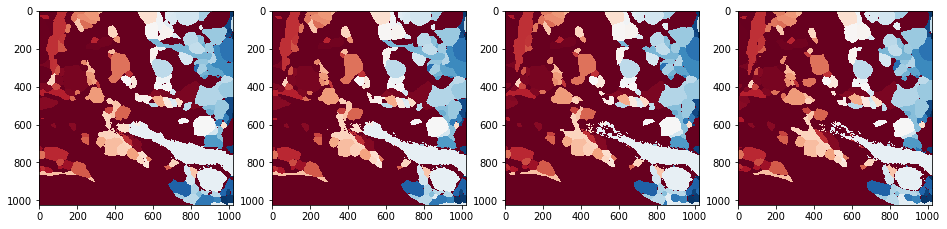

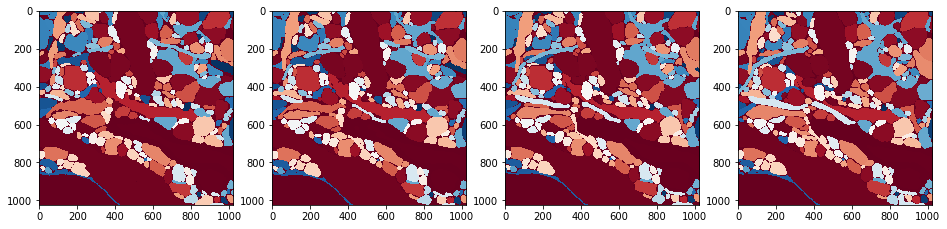

In [8]:
show_imgs(out[0:4], cmap='RdBu')
show_imgs(gt[0:4], cmap='RdBu')

In [9]:
# Try gt affinnity
gt_aff1 = seg_to_affgraph(gt, mknhood3d(1), pad='replicate').astype(np.float32)
out1 = zwatershed(gt_aff1, T_thres, T_aff=T_aff, \
                  T_dust=T_dust, T_merge=T_merge, T_aff_relative=T_aff_rel)[0][0]
out1 = relabel(out1)

gt_aff2 = seg_to_affgraph(widen_border(gt, 1), mknhood3d(1), pad='replicate').astype(np.float32)
out2 = zwatershed(gt_aff2, T_thres, T_aff=T_aff, \
                  T_dust=T_dust, T_merge=T_merge, T_aff_relative=T_aff_rel)[0][0]
out2 = relabel(out2)

gt_aff3 = seg_to_affgraph(widen_border(gt, 2), mknhood3d(1), pad='replicate').astype(np.float32)
out3 = zwatershed(gt_aff3, T_thres, T_aff=T_aff, \
                  T_dust=T_dust, T_merge=T_merge, T_aff_relative=T_aff_rel)[0][0]
out3 = relabel(out3)

# evaluation
score1 = adapted_rand(out1.astype(np.uint32), gt)
score2 = adapted_rand(out2.astype(np.uint32), gt)
score3 = adapted_rand(out3.astype(np.uint32), gt)
print('Adaptive rand: ', score1, score2, score3)

('1. affinity threshold: ', array([0., 1., 1.]))
2. get initial seg
dict_keys([b'counts', b'rg', b'seg'])
('3. do thres: ', 800, 600)
	 number of regions: 400
('1. affinity threshold: ', array([0., 1., 0.]))
2. get initial seg
dict_keys([b'counts', b'rg', b'seg'])
('3. do thres: ', 800, 600)
	 number of regions: 404
('1. affinity threshold: ', array([0., 1., 0.]))
2. get initial seg
dict_keys([b'counts', b'rg', b'seg'])
('3. do thres: ', 800, 600)
	 number of regions: 415
Adaptive rand:  1.3211250582401135e-07 0.06541893138583144 0.11096914691659499


### 4. Generate 3D watershed results (*waterz*)

Generate 3D segmentation results using waterz. Please note that the evaluationn results may not be displayed here. Please check the terminal window running the jupyter notebook for details.

In [11]:
low=0.05; high=0.995
mf = 'aff85_his256';T_thres = [0.2, 0.3, 0.4, 0.5, 0.6]
outs = waterz.waterz(aff, T_thres, merge_function=mf, gt_border=0, output_prefix=mf,
              fragments=None, aff_threshold=[low,high], return_seg=True, gt=gt)

waterz at thresholds [0.2, 0.3, 0.4, 0.5, 0.6]
Compiling waterz in /n/home06/zudilin/.cython/inline


/n/home06/zudilin/app/anaconda3/envs/py3_torch/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /n/home06/zudilin/.cython/inline/waterz_00ac84f324c0714098280627543e2015.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Preparing segmentation volume...
Storing record...
Storing record...
Storing record...
Storing record...
Storing record...
